# **Black-Scholes PINN Approximator**
In this notebook, I'll be approximating the **Black-Scholes** equation using a **Physics-Informed Neural Network** or **PINN**. This will be foundational for when we scale up to the **Heston Model**. We will also cross-validate the data in this notebook with the solution found in our RK4 numerical solver and the PINN will be optimized via a **Sweep**.



---

$$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV = 0
$$
<center>

**Black-Scholes PDE**
</center>

Where:
* $V$: Option price
* $t$: Time
* $S$: Price of the underlying asset
* $\sigma$: Volatility of the underlying asset's returns
* $r$: Risk-free interest rate

---

$$


## **Initialize Model + Define Parameters**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Manually set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class blackScholesPINN(nn.Module):

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),  nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.net(x)

# Black-Scholes parameters (match with RK4 solver)
r = 0.05          # Risk-free rate
sigma = 0.2       # Volatility
K = 100           # Strike price
T = 1.0           # Time to maturity (in years)
S_max = 250       # Max stock price in spatial domain
S_min = 0         # Min stock price
N = 500           # Number of spatial grid points

# Create spatial grid
S = torch.linspace(S_min, S_max, N).view(-1, 1).requires_grad_()
t = torch.linspace(0, T, N).view(-1, 1).requires_grad_()


## **Define Losses**

In [ ]:
def pde_loss(model, S, t):
    S.requires_grad_(True)
    t.requires_grad_(True)
    X = torch.cat((S, t), dim=1)
    V = model(X)

    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_S = torch.autograd.grad(V, S, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]

    residual = V_t + 0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V
    return torch.mean(residual.pow(2))


def boundary_loss(model, t):
    S0 = torch.zeros_like(t)
    S_high = torch.full_like(t, S_max)

    bc_low = model(torch.cat((S0, t), dim=1))
    bc_high = model(torch.cat((S_high, t), dim=1))
    # This is the boundary for a call option
    # It would be K - S_max for a put option
    expected_high = S_max - K * torch.exp(-r * (T - t))

    return torch.mean(bc_low.pow(2)) + torch.mean((bc_high - expected_high).pow(2))


def initial_loss(model, S):
    t0 = torch.zeros_like(S)
    X0 = torch.cat((S, t0), dim=1)

    V_pred = model(X0)
    V_true = torch.clamp(S - K, min=0.0)

    return torch.mean((V_pred - V_true).pow(2))


## **Training Loop**
Due to the complexity of this equation, we add in an adaptive stepper. After trial and error with different weights, it seemed like the next most important hyperparemeter to be tuned was the **learning rate**. I looked up various ways to do adaptive stepping and I stumbled across the **ReduceLROnPlateau** function within the PyTorch library. This function will monitor our total loss and reduce our learning rate when we begin to plateau.

In [ ]:
# Initialize model, optimizer, and training parameters
model = blackScholesPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 4000
loss_history = []

# Weights for each loss component (tuned via a series of sweeps)
pde_weight = 14.46
bc_weight = 0.086
ic_weight = 0.05

print(f'Weights - PDE: {pde_weight}, BC: {bc_weight}, IC: {ic_weight}')

# Adaptive learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, min_lr=1e-7, verbose=True)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    V = model(torch.cat((S, t), dim=1))

    # Compute losses
    pde_l = pde_loss(model, S, t)
    bc_l = boundary_loss(model, t)
    ic_l = initial_loss(model, S)
    total_loss = (pde_weight * pde_l) + (bc_weight * bc_l) + (ic_weight * ic_l)

    total_loss.backward()
    optimizer.step()

    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(total_loss)
    else:
        scheduler.step()

    loss_history.append(total_loss.item())
    current_lr = optimizer.param_groups[0]['lr']


    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.3f}, PDE Loss: {pde_l.item():.3f}, BC Loss: {bc_l.item():.3f}, IC Loss: {ic_l.item():.3f}, LR: {current_lr:.6f}')

Weights - PDE: 14.46, BC: 0.086, IC: 0.05


c:\Users\tobys\anaconda3\envs\star-pinn\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2224.400, PDE Loss: 0.000, BC Loss: 23242.812, IC Loss: 4510.353, LR: 0.005000
Epoch 500, Loss: 17.155, PDE Loss: 0.001, BC Loss: 14.333, IC Loss: 318.196, LR: 0.000000
Epoch 1000, Loss: 17.142, PDE Loss: 0.001, BC Loss: 15.056, IC Loss: 316.669, LR: 0.000000
Epoch 1500, Loss: 17.125, PDE Loss: 0.001, BC Loss: 15.734, IC Loss: 315.170, LR: 0.000000
Epoch 2000, Loss: 17.107, PDE Loss: 0.001, BC Loss: 16.299, IC Loss: 313.851, LR: 0.000000
Epoch 2500, Loss: 17.088, PDE Loss: 0.001, BC Loss: 16.645, IC Loss: 312.864, LR: 0.000000


### **Plot Loss**

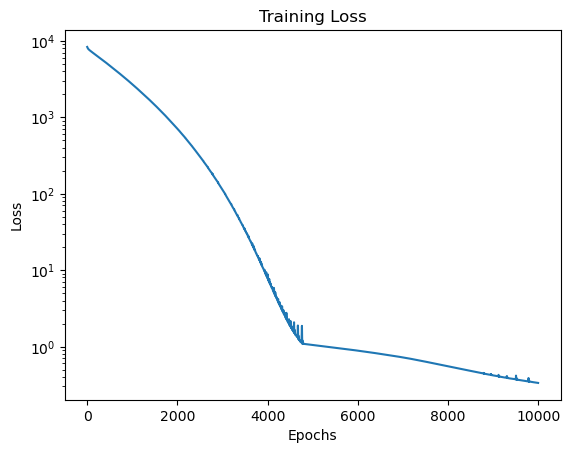

In [ ]:
plt.plot(loss_history)
plt.title('Training Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### **Sweep**

In [ ]:
import wandb
import math # For math.prod if needed for debugging

# --- IMPORTANT: Your PINN Model and Loss Functions ---
# Make sure your blackScholesPINN class, pde_loss, boundary_loss, initial_loss
# functions, and S, t tensors are defined in previous cells or imported.
# For example:
# from your_module import blackScholesPINN, pde_loss, boundary_loss, initial_loss, S, t
# If they are not globally available, you might need to pass them or define them inside train_pinn_sweep.
# For simplicity, this assumes they are already defined when this cell runs.

# Define the sweep configuration
# We'll use 'random' search to efficiently explore the weight space.
# The 'metric' defines what we are trying to optimize (minimize final_total_loss).
# 'parameters' define the ranges/distributions for the hyperparameters we want to tune.

sweep_config = {
    'method': 'random', # or 'grid' or 'bayes'
    'metric': {
        'name': 'final_total_loss',
        'goal': 'minimize'
    },
    'parameters': {
        # Initial Learning Rate (Still good to sweep, as it affects where scheduler starts)
        'initial_lr': {
            'min': 0.0001,
            'max': 0.005,
            'distribution': 'log_uniform_values' # Log uniform is good for LR
        },
        # Patience for LR scheduler (how long to wait before reducing)
        'lr_patience': {
            'min': 100,
            'max': 500,
            'distribution': 'int_uniform' # Integer values
        },
        # Factor for LR reduction (e.g., 0.1 for 10x, 0.5 for 2x)
        'lr_factor': {
            'min': 0.05,
            'max': 0.5,
            'distribution': 'uniform'
        },
        # Loss Weights - This is the core of this sweep
        # We'll define them as relative scales, then normalize in the training function
        # This allows you to explore their influence independently before normalizing.
        'pde_weight_scale': {
            'min': 0.1, # Min relative scale for PDE loss
            'max': 10.0, # Max relative scale for PDE loss (can go higher if PDE is very hard)
            'distribution': 'log_uniform_values'
        },
        'bc_weight_scale': {
            'min': 0.1, # Min relative scale for BC loss
            'max': 10.0, # Max relative scale for BC loss
            'distribution': 'log_uniform_values'
        },
        'ic_weight_scale': {
            'min': 0.1, # Min relative scale for IC loss
            'max': 10.0, # Max relative scale for IC loss
            'distribution': 'log_uniform_values'
        },
        # Network architecture (optional, but good to include in a later sweep)
        # 'hidden_layers': {
        #     'values': [4, 6, 8] # Number of hidden layers
        # },
        # 'neurons_per_layer': {
        #     'values': [64, 128, 256] # Number of neurons per layer
        # }
    }
}

# The training function that will be run by each sweep agent
def train_pinn_sweep():
    # Initialize a new W&B run for this trial
    wandb.init()

    # Access hyperparameters for the current run
    config = wandb.config

    # Normalize weights to sum to 1, or use them as raw scaling factors
    # It's often better to use them as raw scaling factors if you don't enforce a sum=1
    # and let the network decide which loss needs more attention.
    # If you want to enforce sum=1:
    # total_scale = config.pde_weight_scale + config.bc_weight_scale + config.ic_weight_scale
    # pde_weight = config.pde_weight_scale / total_scale
    # bc_weight = config.bc_weight_scale / total_scale
    # ic_weight = config.ic_weight_scale / total_scale
    # Or, use them directly as they are more like penalty terms:
    pde_weight = config.pde_weight_scale
    bc_weight = config.bc_weight_scale
    ic_weight = config.ic_weight_scale


    # Initialize model and optimizer with hyperparameters from config
    model = blackScholesPINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.initial_lr)

    # Adaptive learning rate scheduler using config values
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=config.lr_factor,
        patience=config.lr_patience,
        min_lr=1e-7, # Keep a very low min_lr
        verbose=True
    )

    epochs = 10000 # Keep fixed for this sweep, or make it a sweep param too
    
    # Store individual loss components (optional but good for analysis)
    run_pde_loss_history = []
    run_bc_loss_history = []
    run_ic_loss_history = []
    run_total_loss_history = []

    print(f"Starting run with Weights: PDE={pde_weight:.2e}, BC={bc_weight:.2e}, IC={ic_weight:.2e}, "
          f"Initial LR={config.initial_lr:.2e}, Patience={config.lr_patience}, Factor={config.lr_factor:.2f}")

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Ensure S and t are on the correct device (e.g., GPU if available)
        # S = S.to(device)
        # t = t.to(device)
        V = model(torch.cat((S, t), dim=1))

        # Compute losses
        pde_l = pde_loss(model, S, t)
        bc_l = boundary_loss(model, t)
        ic_l = initial_loss(model, S)
        
        # Calculate total loss using the swept weights
        total_loss = (pde_weight * pde_l) + (bc_weight * bc_l) + (ic_weight * ic_l)

        total_loss.backward()
        optimizer.step()

        # Step the scheduler (pass total_loss for ReduceLROnPlateau)
        scheduler.step(total_loss)

        current_lr = optimizer.param_groups[0]['lr']

        # Log metrics to W&B for each epoch
        wandb.log({
            "epoch": epoch,
            "total_loss": total_loss.item(),
            "pde_loss": pde_l.item(),
            "bc_loss": bc_l.item(),
            "ic_loss": ic_l.item(),
            "learning_rate": current_lr,
            "bc_loss_norm_factor": bc_l.item() / (total_loss.item() + 1e-9), # Debugging loss contributions
            "ic_loss_norm_factor": ic_l.item() / (total_loss.item() + 1e-9)
        })

        run_total_loss_history.append(total_loss.item())
        run_pde_loss_history.append(pde_l.item())
        run_bc_loss_history.append(bc_l.item())
        run_ic_loss_history.append(ic_l.item())


        if epoch % 500 == 0 or epoch == epochs - 1: # Print at intervals and at the very end
            print(f'Epoch {epoch}, Total Loss: {total_loss.item():.6f}, '
                  f'PDE Loss: {pde_l.item():.6f}, BC Loss: {bc_l.item():.6f}, '
                  f'IC Loss: {ic_l.item():.6f}, '
                  f'LR: {current_lr:.8f}')
            
    # Log the final total loss as the sweep metric
    wandb.log({"final_total_loss": total_loss.item()})

    # You can also log final individual losses
    wandb.log({
        "final_pde_loss": pde_l.item(),
        "final_bc_loss": bc_l.item(),
        "final_ic_loss": ic_l.item()
    })
    
    # End the W&B run for this trial
    wandb.finish()

# --- Initialize and run the Sweep ---
# Create a unique sweep ID. This will output instructions to run agents.
# You can give your project a specific name here.
sweep_id = wandb.sweep(sweep_config, project="PINN_Loss_Weight_Sweep")

print(f"Sweep ID: {sweep_id}")
print("Run the following command in your terminal to start sweep agents:")
print(f"wandb agent {sweep_id}")
print("\nAlternatively, to run agents directly in this notebook (for local testing):")
print(f"wandb.agent('{sweep_id}', function=train_pinn_sweep, count=5)") # Runs 5 trials in this cell
